In this notebook, we visualize the 1D coding scheme for approximation of continuous functions in supremum norm with activations corresponding to SG-LReLUs and S-ReLUs given by the sets $\mathcal{F}_{\pm,\mathfrak{s}}$ and $\mathcal{F}_{+,\mathfrak{s}}$ from the paper, respectively. Note that these are the larger LReLU sets in which we directly build our LReLU constructions. For the single-parameter sets, we would further need to approximate the LReLUs from this construction with width-one LReLU networks, resulting in super-exponential depth. Therefore, we omit doing this here and only work with the construction using the large LReLU sets; otherwise, runtime will explode even for very small parameters, making the code and visualizations tediously slow.

In contrast to the $L^p$ approximation case, we now include stepped and generalized LReLUs, i.e., discontinuities at zero and non-monotone LReLUs. By using the steps especially for the encoder, we can achieve small supremum norm error over the entire unit interval and additionally exact fitting of the encoder on the set of binary numbers $\mathcal{C}_{K}$. Note that our continuous construction from the $L^p$ notebook cannot achieve this.

In [1]:
import torch
import matplotlib.pyplot as plt
from coding_scheme_base_functions import (Sigma_ab_cd, EncoderApprox1D, ZigZagMemorizer, PLCSMMemorizer,  CodingScheme1D, EncoderSupApprox1D, EncoderExact1D)

In [2]:
# set the device and dtype (torch.float64 is recommended for precision) of your choice
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64

## Part 1: Supremum Encoder Approximation

We begin with our encoder construction. The shifted and rescaled LReLU variants $\sigma_{a,b}^{c,d}$ are constructed as shown in [coding_scheme_1D.ipynb](coding_scheme_1D.ipynb). We use them here too, but keep the visualization in that file.

Note that in the 1D case, the encoder corresponds directly to the quantizer, so these two components are equivalent. Furthermore, the decoder in 1D is simply the identity function, which is why we do not need to construct it separately.

**Parameter Control for Convergence:**
- **slope $\to 0$**: This parameter controls how closely the encoder approximation matches the true encoder. As it approaches zero, the approximation becomes more accurate.
- **Note**: We don't have the $\gamma$ parameter from the $L^p$ encoder, as it corresponded to the volume of the sets where our encoder had large differences from the true encoder. In the supremum case, we use discontinuities to achieve exact fitting on the binary numbers $\mathcal{C}_K$, eliminating the need for this parameter.

Now we show how well the supremum encoder with discontinuous activations can approximate the exact encoder using different values of the slope parameter to demonstrate convergence.

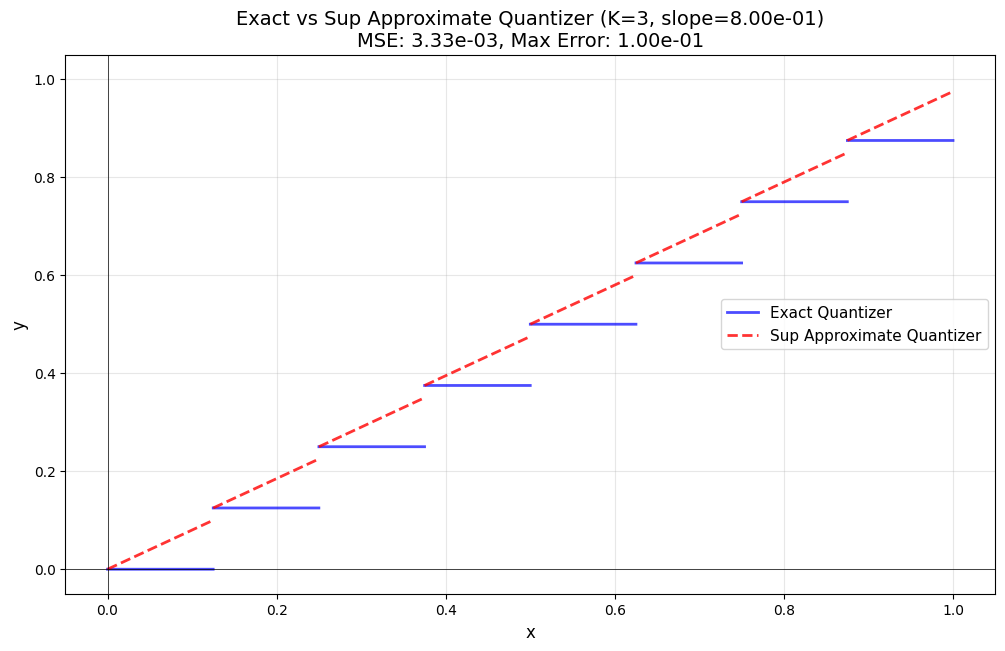

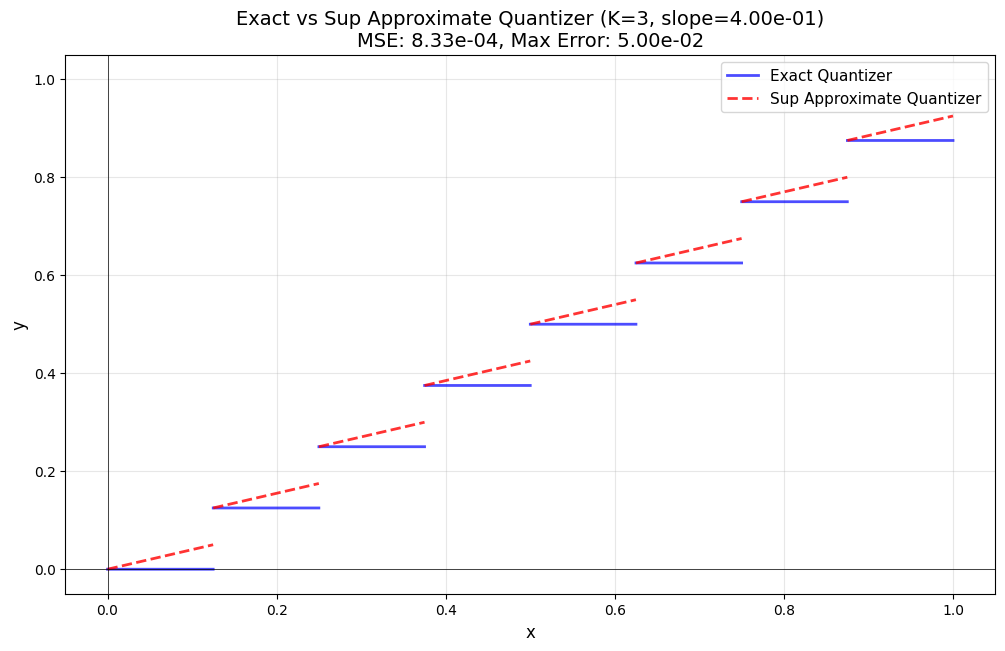

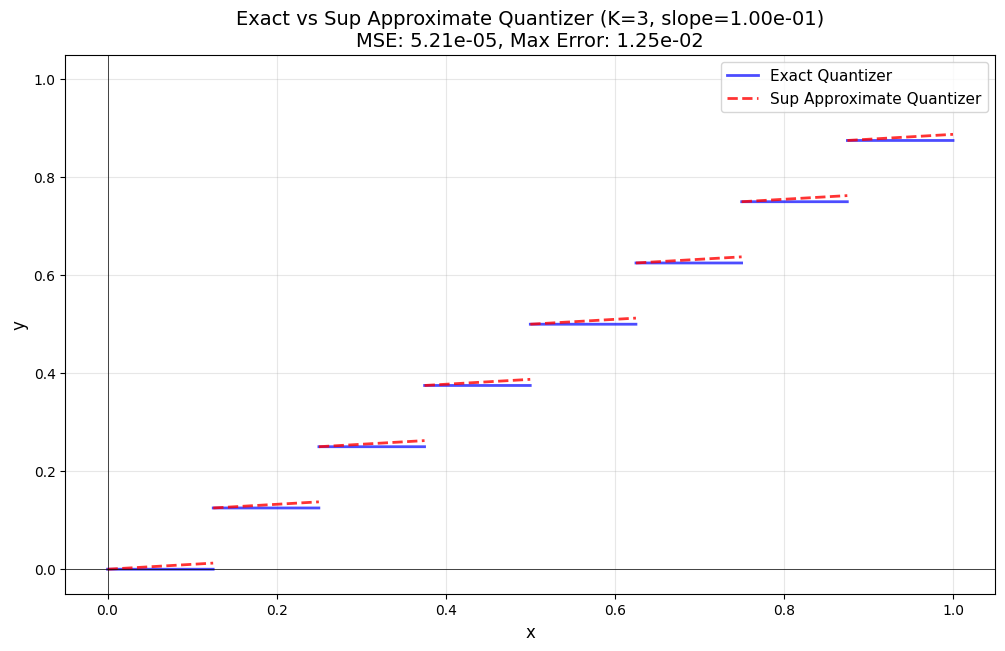

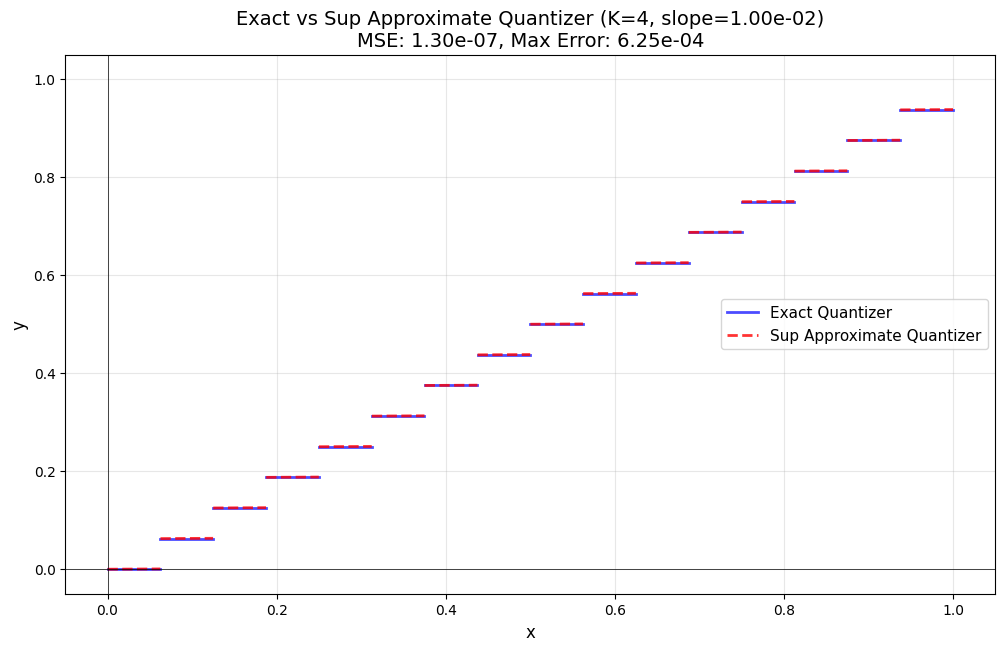

In [12]:
# create supremum encoders with different flat_slope values and plot them against exact encoder
encoder_sup1 = EncoderSupApprox1D(K=3, slope=8e-1, dtype=dtype, device=device)
encoder_sup2 = EncoderSupApprox1D(K=3, slope=4e-1, dtype=dtype, device=device)
encoder_sup3 = EncoderSupApprox1D(K=3, slope=1e-1, dtype=dtype, device=device)
encoder_sup4 = EncoderSupApprox1D(K=4, slope=1e-2, dtype=dtype, device=device)

# plot supremum encoders with exact encoder for comparison (capturing return values to suppress printed tuples)
_ = encoder_sup1.plot_with_exact(show_title=True)
_ = encoder_sup2.plot_with_exact(show_title=True)
_ = encoder_sup3.plot_with_exact(show_title=True)
_ = encoder_sup4.plot_with_exact(show_title=True)

## Test Functions

These are the functions that we want to approximate. We select them to include both non-monotonic and discontinuous functions, demonstrating the versatility of our coding scheme.

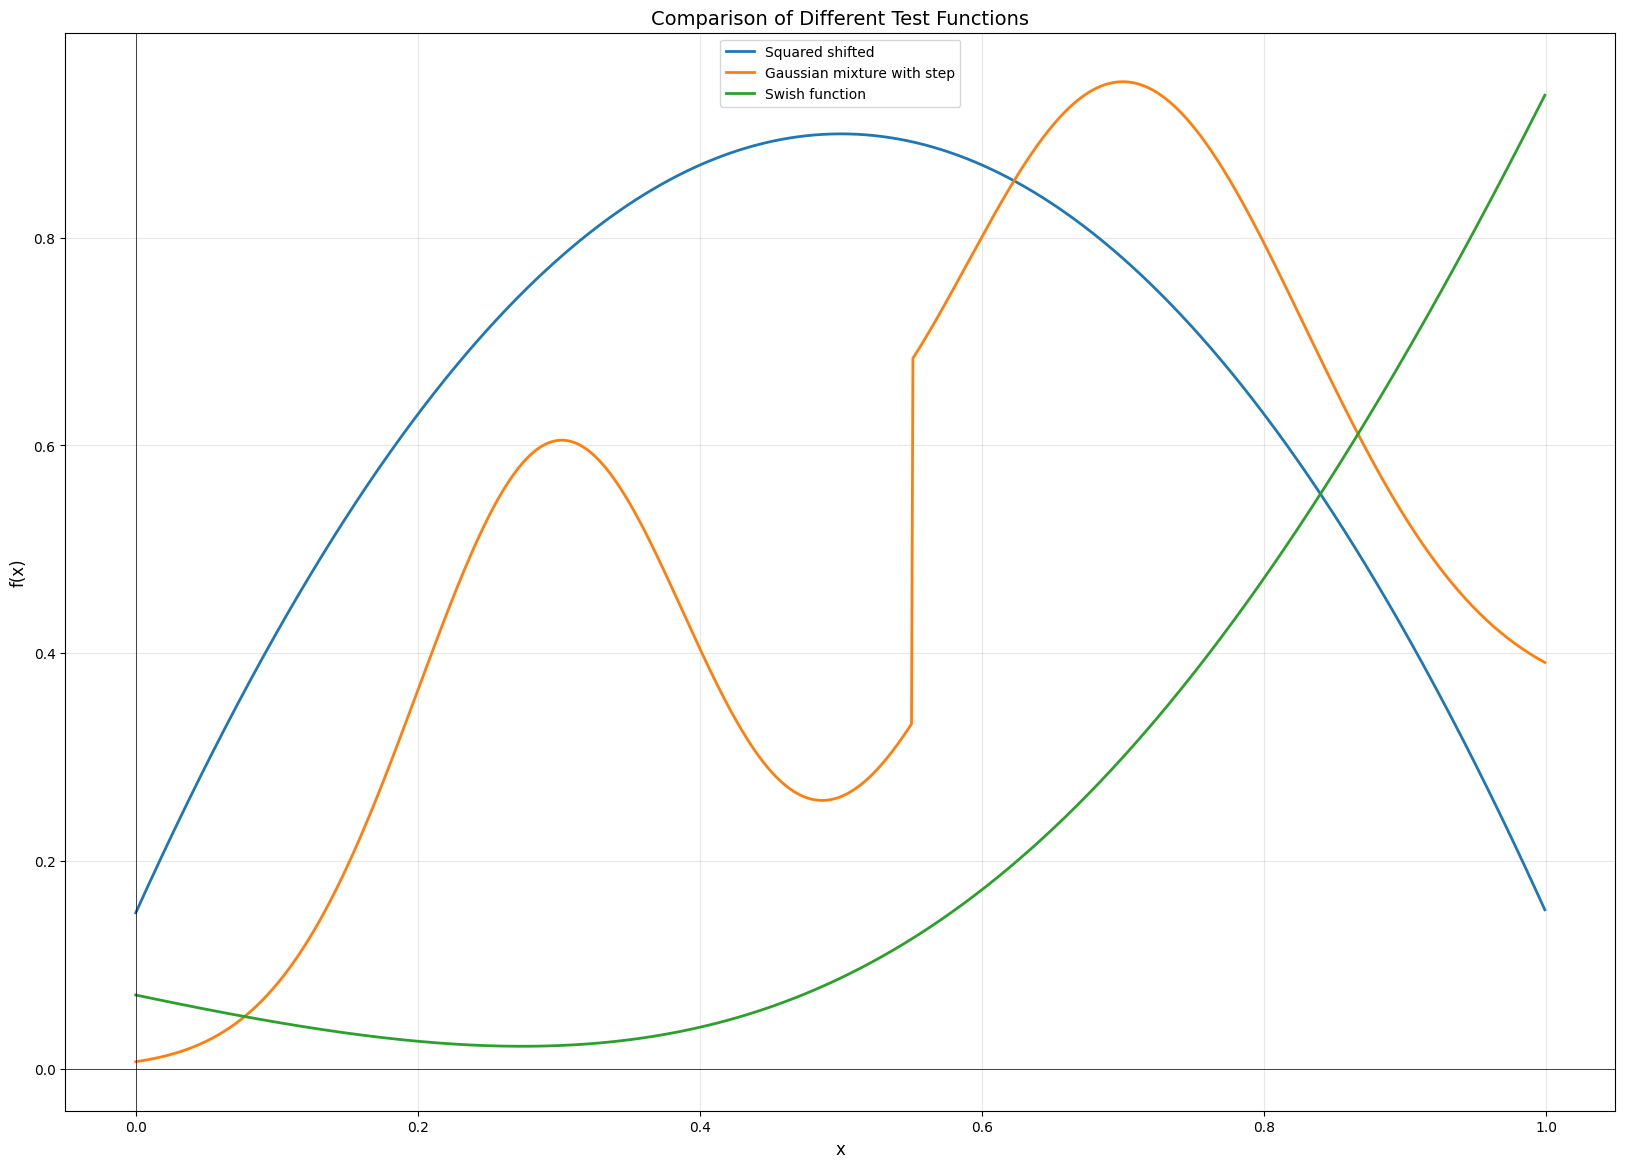

In [ ]:
# Define test functions for approximation
def squared_shifted(x):
    return -3 * (x - 0.5) ** 2 + 0.9

def smooth_gaussian_mixture(x):
    # Continuous multi-peak Gaussian mixture
    return 0.5 * torch.exp(-80 * (x - 0.25) ** 2) + 0.7 * torch.exp(-60 * (x - 0.6) ** 2) + 0.4 * torch.exp(-100 * (x - 0.85) ** 2) + 0.1

def swish_shifted(x):
    return 3 * (x - 0.7) * torch.sigmoid(3 * (x - 0.7)) + 0.3

# SELECT BASE FUNCTION HERE - Change this to use a different function throughout the notebook
base_function = squared_shifted
base_function_name = "Squared Shifted Function"

# Alternative options (uncomment to use):
# base_function = smooth_gaussian_mixture
# base_function_name = "Smooth Gaussian Mixture Function"

# base_function = swish_shifted
# base_function_name = "Swish Shifted Function"

# Optional: Plot comparison of functions (comment out if not needed)
def plot_test_functions(function_list):
    """
    Plot multiple test functions for comparison.
    
    Args:
        function_list: List of tuples (function, name) to plot
    """
    points = torch.arange(0, 1, 0.001, dtype=dtype, device=device)
    plt.figure(figsize=(20, 14))
    for func, name in function_list:
        plt.plot(points.cpu().numpy(), func(points).cpu().numpy(), label=name, linewidth=2)
    plt.grid(True, alpha=0.3)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('f(x)', fontsize=12)
    plt.title('Comparison of Different Test Functions', fontsize=14)
    plt.axhline(y=0, color='k', linewidth=0.5)
    plt.axvline(x=0, color='k', linewidth=0.5)
    plt.legend()
    plt.show()

# Comparison plot of all test functions
# Add your own functions to the list if desired: [(your_function, "Your Function Name"), ...]
plot_test_functions([
    (squared_shifted, "Squared shifted"),
    (smooth_gaussian_mixture, "Smooth Gaussian mixture"),
    (swish_shifted, "Swish shifted")
])

## Part 2: Supremum Coding Scheme with Zig-Zag Memorizer

Now we demonstrate the zig-zag memorizer construction for supremum norm approximation using the selected base function. The zig-zag memorizer fits the function exactly on finitely many points.

Recall that in 1D, the complete coding scheme is given by the encoder (quantizer) composed with the memorizer, since the decoder is simply the identity function.

**🔑 Key Insight - Network Width:**
- **Zig-Zag Memorizer = Width-1 FNN**: The zig-zag memorizer is a purely width-one feedforward neural network
- **Coding Scheme with Zig-Zag = Width-1**: The complete coding scheme (encoder + memorizer) is width-1
- **Built from scratch**: Everything constructed using only our $\sigma_{a,b}^{c,d}$ functions - simple width-1 LReLU compositions!

This proves that universal approximation in supremum norm is achievable with **minimal width** (width-1).

**Parameter Control for Coding Scheme Accuracy:**
- **$K \to \infty$** and **$M \to \infty$**: These parameters control how well the coding scheme fits the base function. Larger values result in better approximation of the target function, as the memorizer can fit more points with higher precision.
- Combined with the encoder parameter (slope $\to 0$), the complete coding scheme converges to the true coding scheme construction.
- **⚠️ Warning**: Large $K$ values lead to **exponential runtime increase** (number of function compositions grows as $2^K$). Values $K > 10$ may result in significant slowdown. Additionally, large $K$ and $M$ values can cause numerical instabilities due to the complexity of the composed functions.

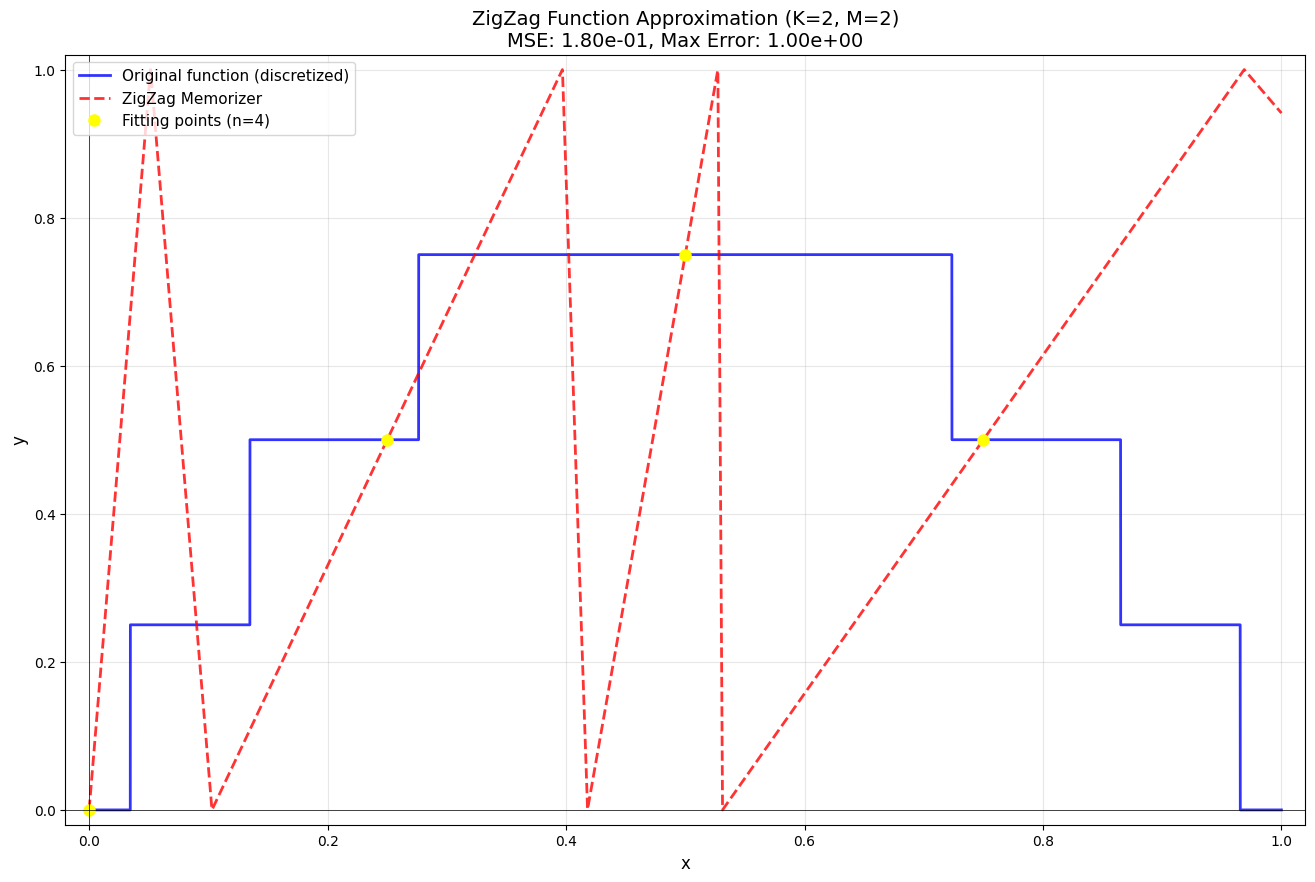

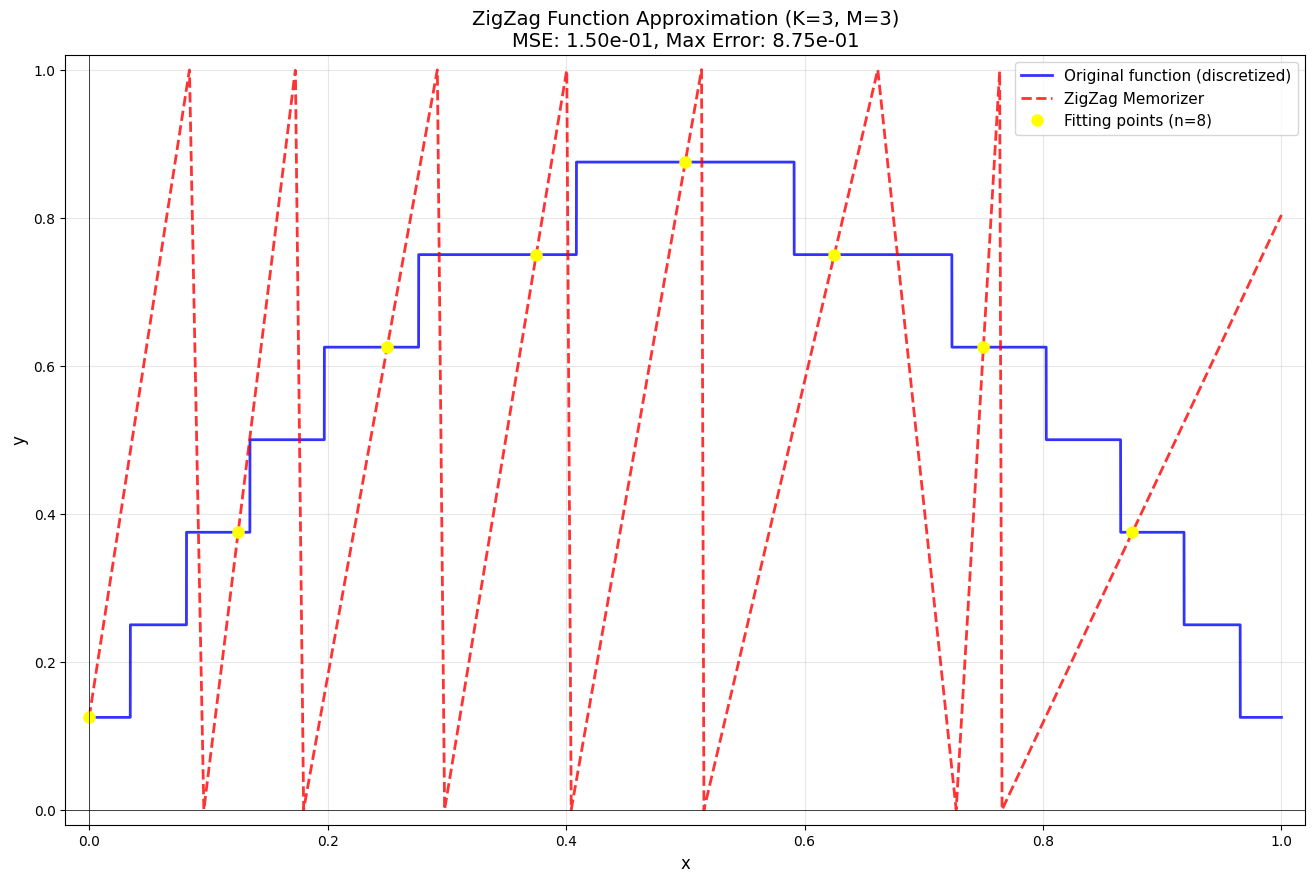

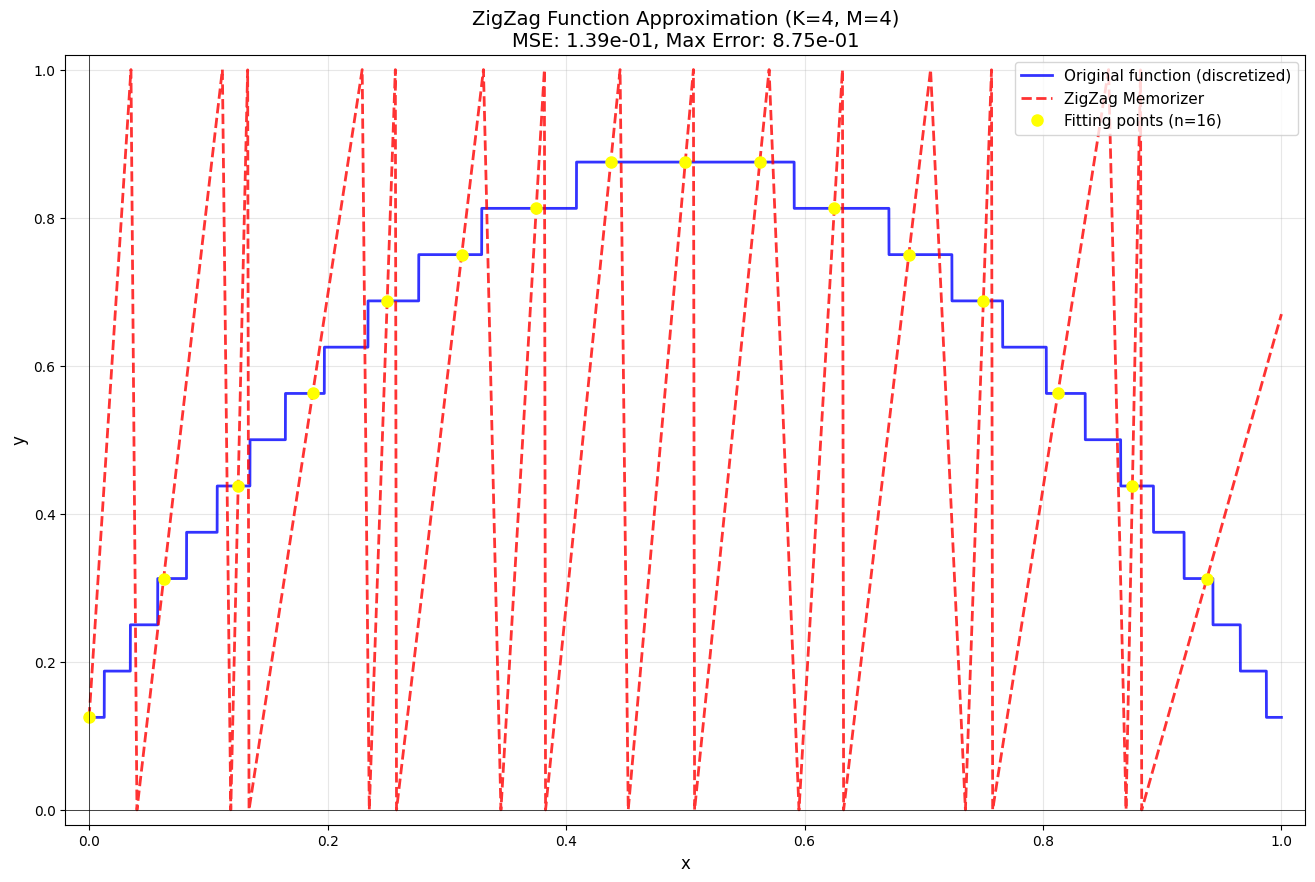

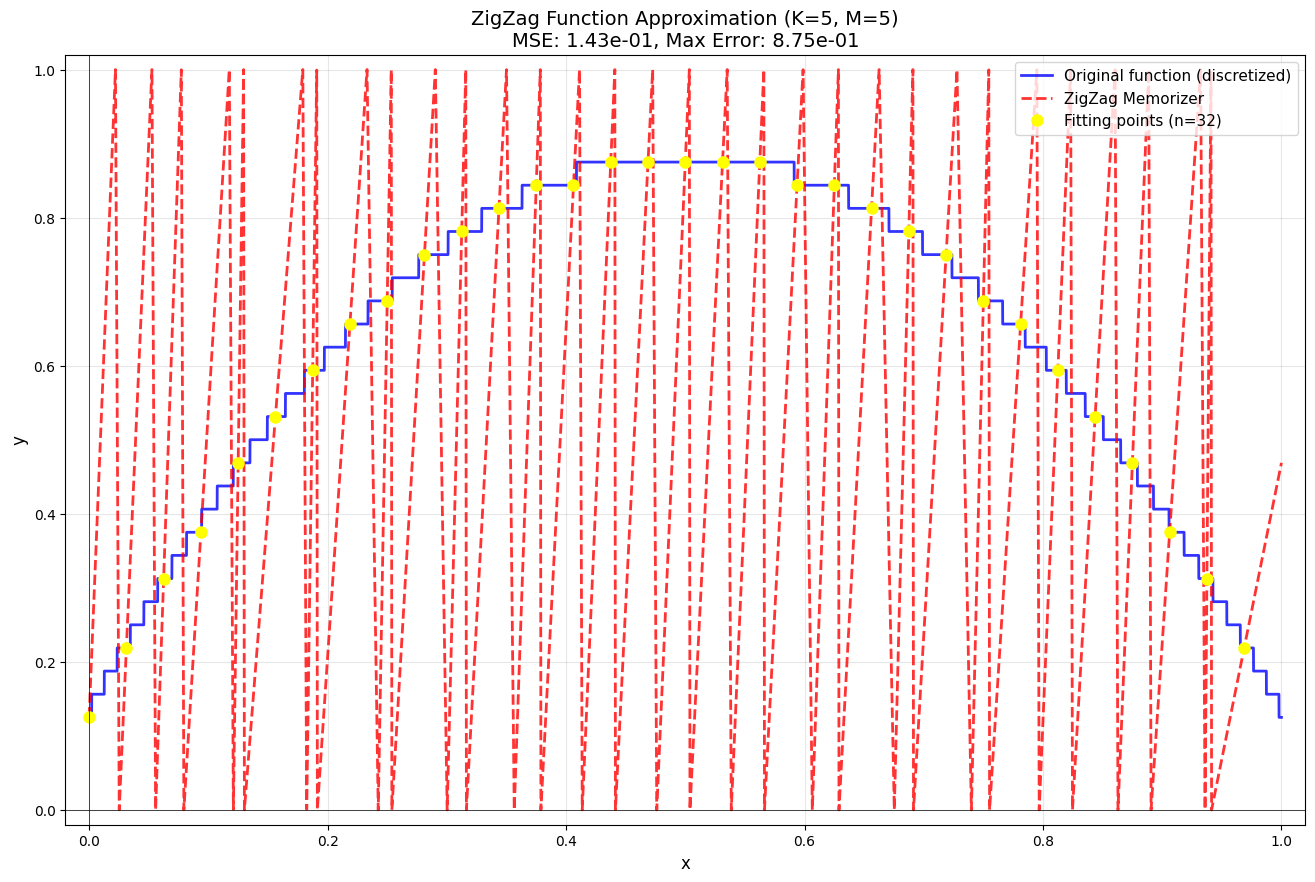

In [5]:
# Define parameter list for zig-zag memorizer demonstrations
zigzag_param_list = [(2, 2), (3, 3), (4, 4), (5, 5)]

# Demonstrate zig-zag memorizer with base function comparison for multiple parameters
zig_zag_memorizer = ZigZagMemorizer(base_function, K=2, M=2, dtype=dtype, device=device)
zig_zag_memorizer.plot_with_base_function_for_parameter_list(zigzag_param_list)

# Optional: Plot only the memorizers without base function (uncomment to use)
# Uncomment the line below to see only the zig-zag memorizer shapes for each parameter combination
# zig_zag_memorizer.plot_for_parameter_list(zigzag_param_list)

### Zig-Zag Supremum Coding Scheme Evaluation

Now we evaluate the complete supremum coding scheme with the zig-zag memorizer. The encoder is composed with the memorizer function to form the full coding scheme.

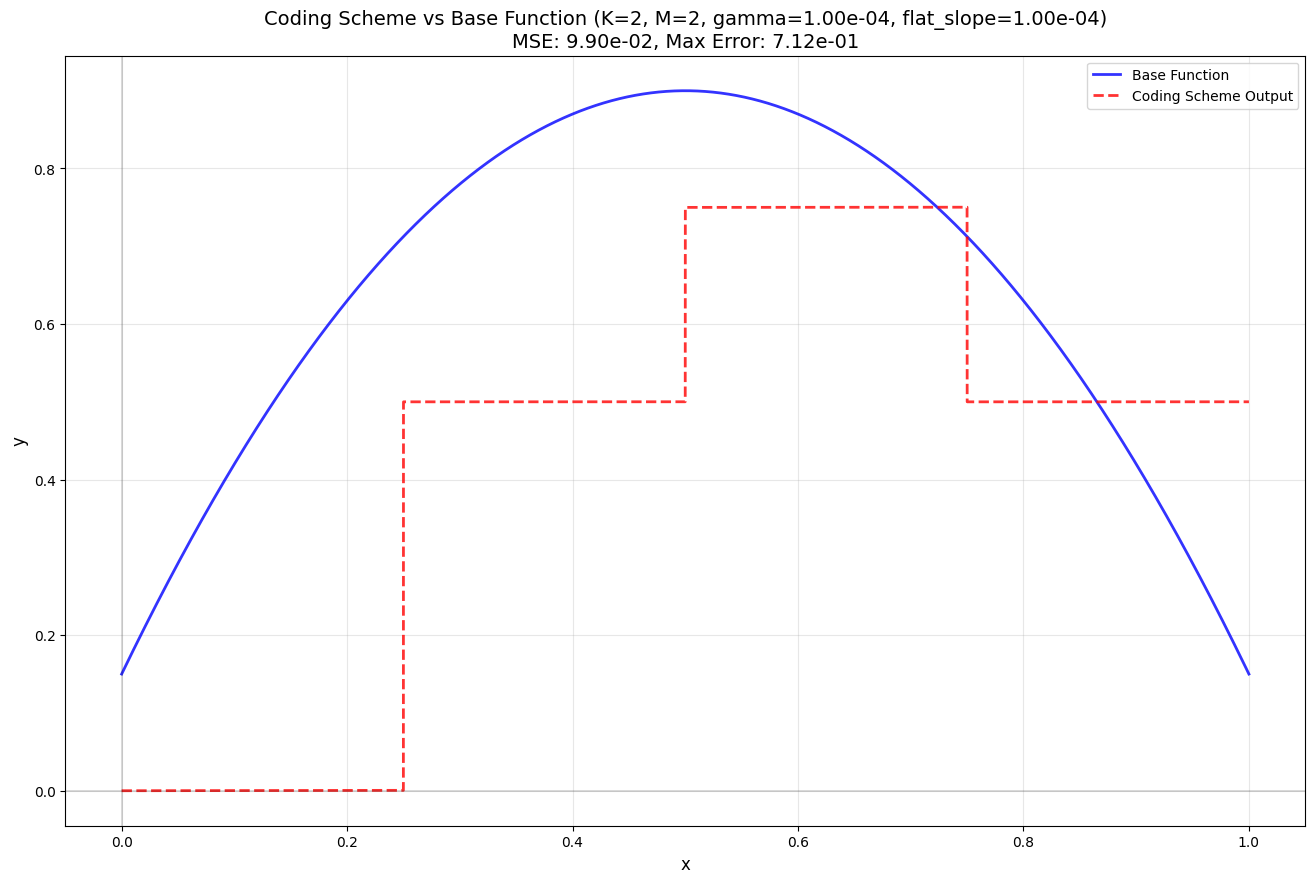

For Squared Shifted Function with Zig-Zag (Supremum) with parameters K=2, M=2, gamma=1.00e-04, flat_slope=1.00e-04:
 - L2 error: 3.15e-01, Max error: 7.12e-01


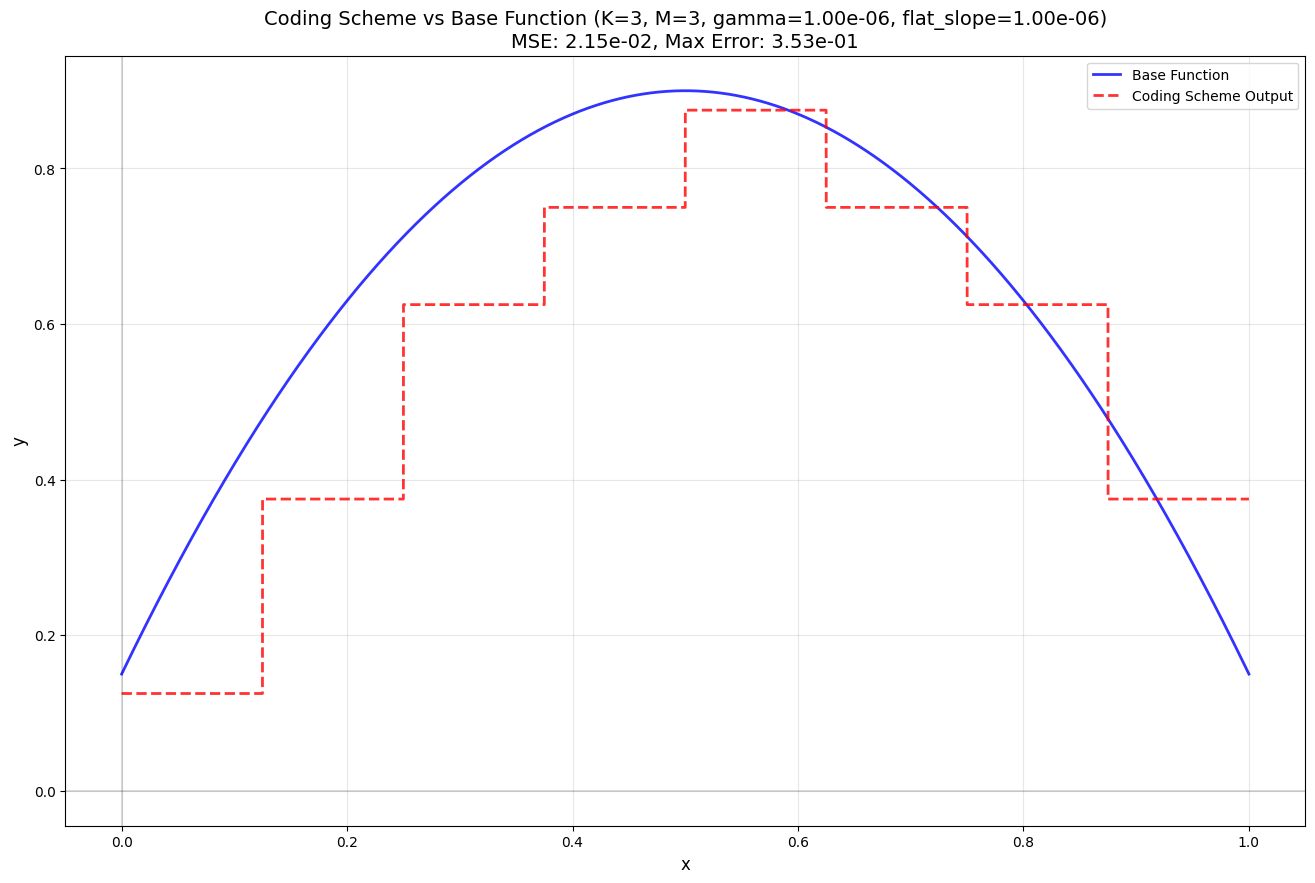

For Squared Shifted Function with Zig-Zag (Supremum) with parameters K=3, M=3, gamma=1.00e-06, flat_slope=1.00e-06:
 - L2 error: 1.47e-01, Max error: 3.53e-01


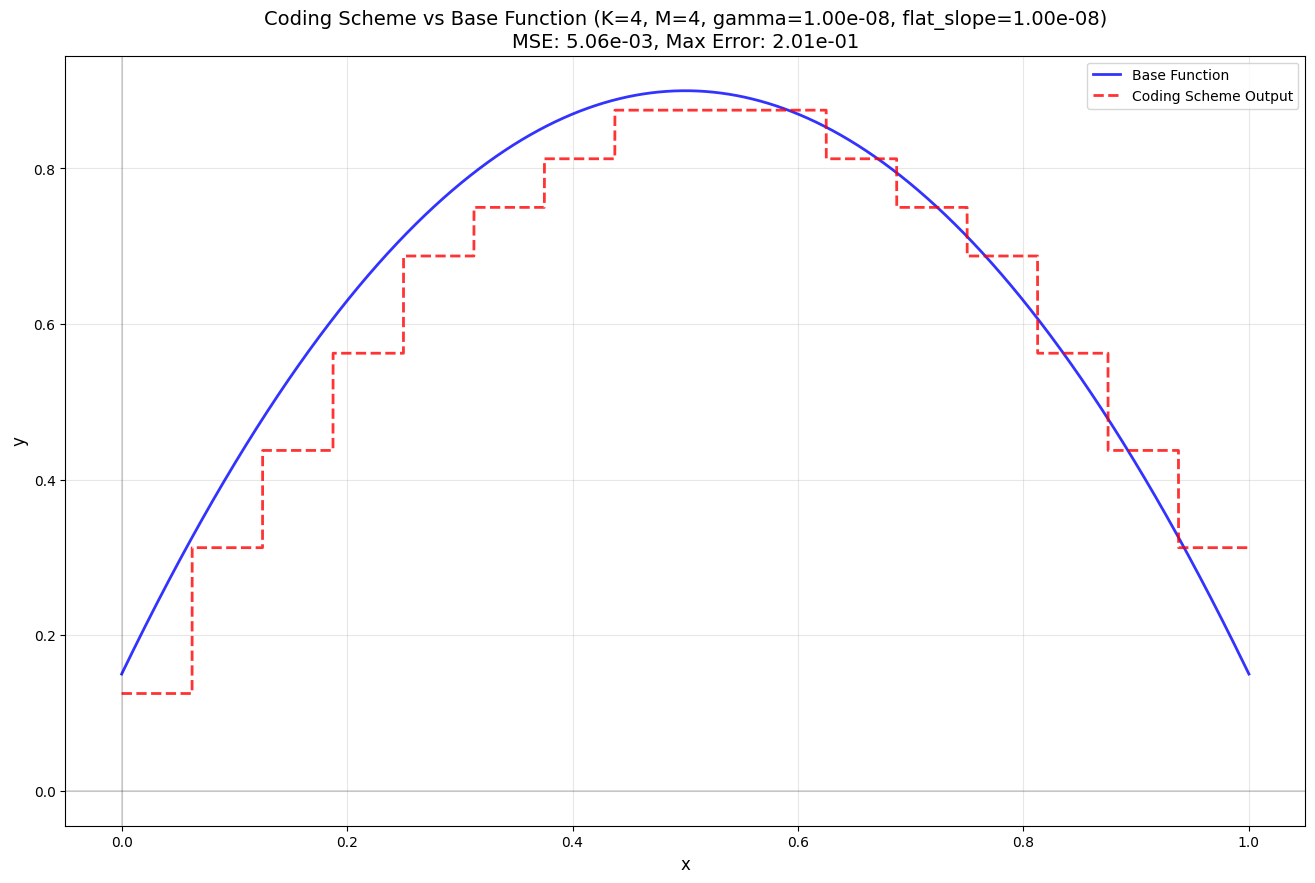

For Squared Shifted Function with Zig-Zag (Supremum) with parameters K=4, M=4, gamma=1.00e-08, flat_slope=1.00e-08:
 - L2 error: 7.11e-02, Max error: 2.01e-01


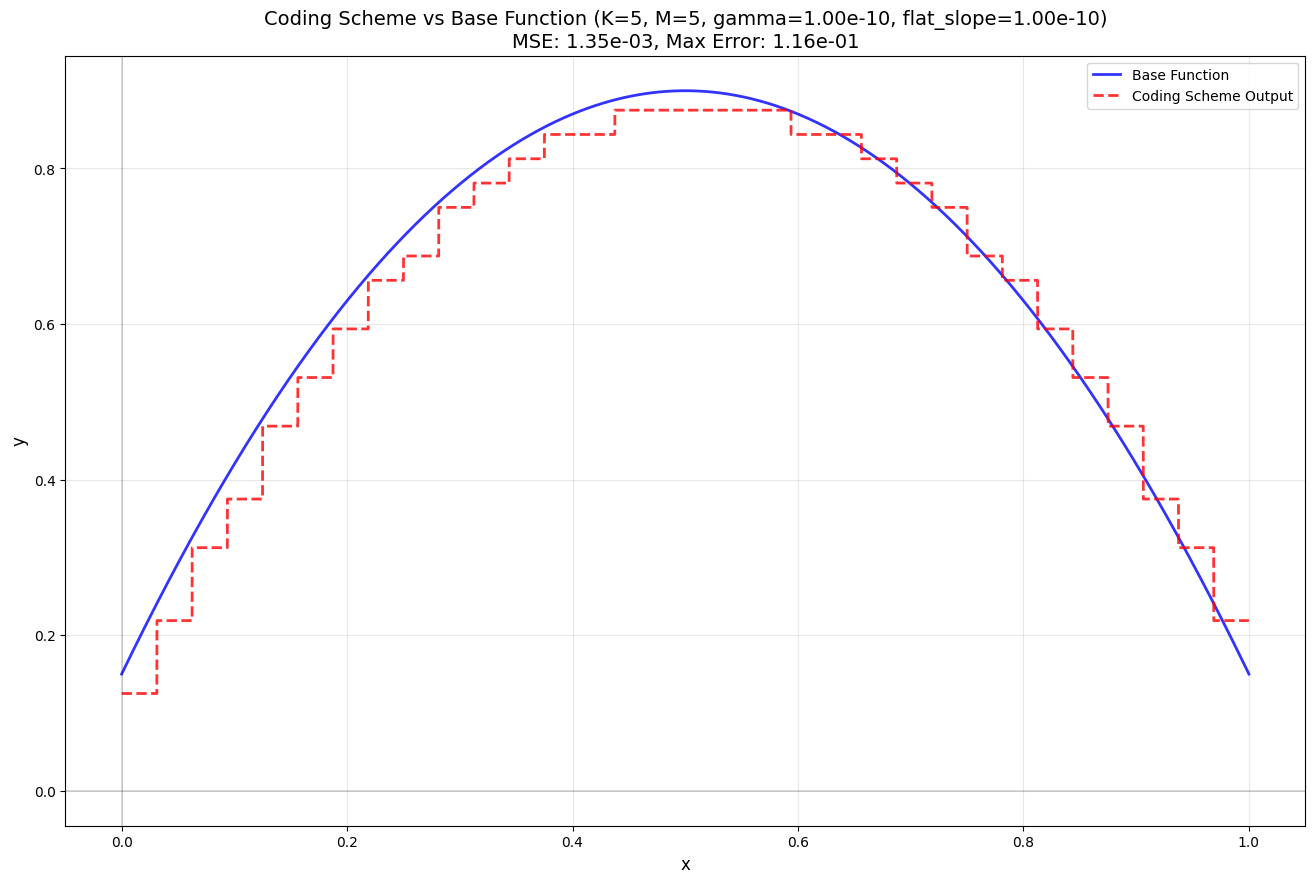

For Squared Shifted Function with Zig-Zag (Supremum) with parameters K=5, M=5, gamma=1.00e-10, flat_slope=1.00e-10:
 - L2 error: 3.68e-02, Max error: 1.16e-01


[(2, 2, 0.0001, 0.0001, 0.31459588765769325, 0.7119023094206052),
 (3, 3, 1e-06, 1e-06, 0.14668422757513794, 0.35292701285231165),
 (4, 4, 1e-08, 1e-08, 0.07108745824897475, 0.20053509330596564),
 (5, 5, 1e-10, 1e-10, 0.036776436999170256, 0.11568845666501815)]

In [ ]:
# Create and evaluate supremum coding scheme with zig-zag memorizer
coding_scheme_zigzag_sup = CodingScheme1D(base_function, memorizer_type="zig-zag", dtype=dtype, device=device, scheme_type="sup")

# Evaluate for multiple parameter combinations (errors are displayed in plots)
zigzag_sup_params = [(2,2,1e-4,1e-4), (3,3,1e-6,1e-6), (4,4,1e-8,1e-8), (5,5,1e-10,1e-10)]
_ = coding_scheme_zigzag_sup.evaluate_for_list_of_parameters(zigzag_sup_params, f"{base_function_name} with Zig-Zag (Supremum)", plot=True)

## Part 3: Supremum Coding Scheme with PLCSM Memorizer

The PLCSM (Piecewise Linear Continuous Slope Matching) memorizer ensures continuous derivatives, providing smoother approximations.

**🔑 Key Insight - Network Width:**
- **PLCSM Memorizer = Width-2 FNN**: PLCSM requires width-2, unlike the width-1 zig-zag construction
- **Coding Scheme with PLCSM = Width-2**: The complete coding scheme now uses width-2
- **⚠️ Critical Comparison**: PLCSM approximations typically look better visually, but use **double the network width** compared to zig-zag! This is comparatively very unfair - achieving good results with width-1 is **terrifically harder**. The zig-zag width-1 results are therefore much more impressive.
- **Still from scratch**: PLCSM is built entirely from our $\sigma_{a,b}^{c,d}$ width-1 LReLU compositions

Keep in mind that width-2 networks have significantly more expressiveness than width-1 when comparing the results.

**Parameter Control:**
- **$K$, $M$**: Control discretization levels and fitting precision
- **flat_slope**: Smoothness parameter (should converge to 0)
- **⚠️ Warning**: Large $K$ and $M$ cause exponential runtime and numerical instabilities.

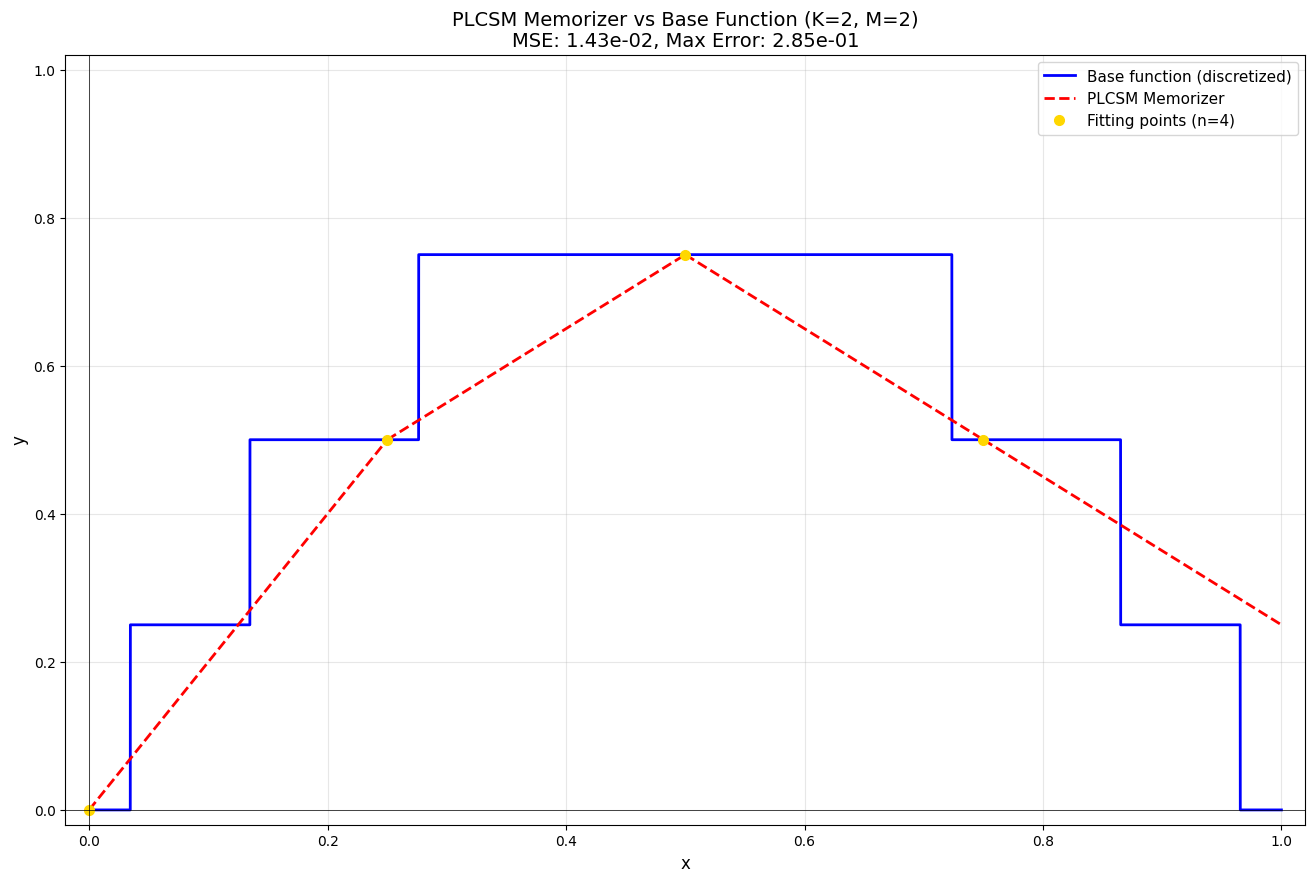

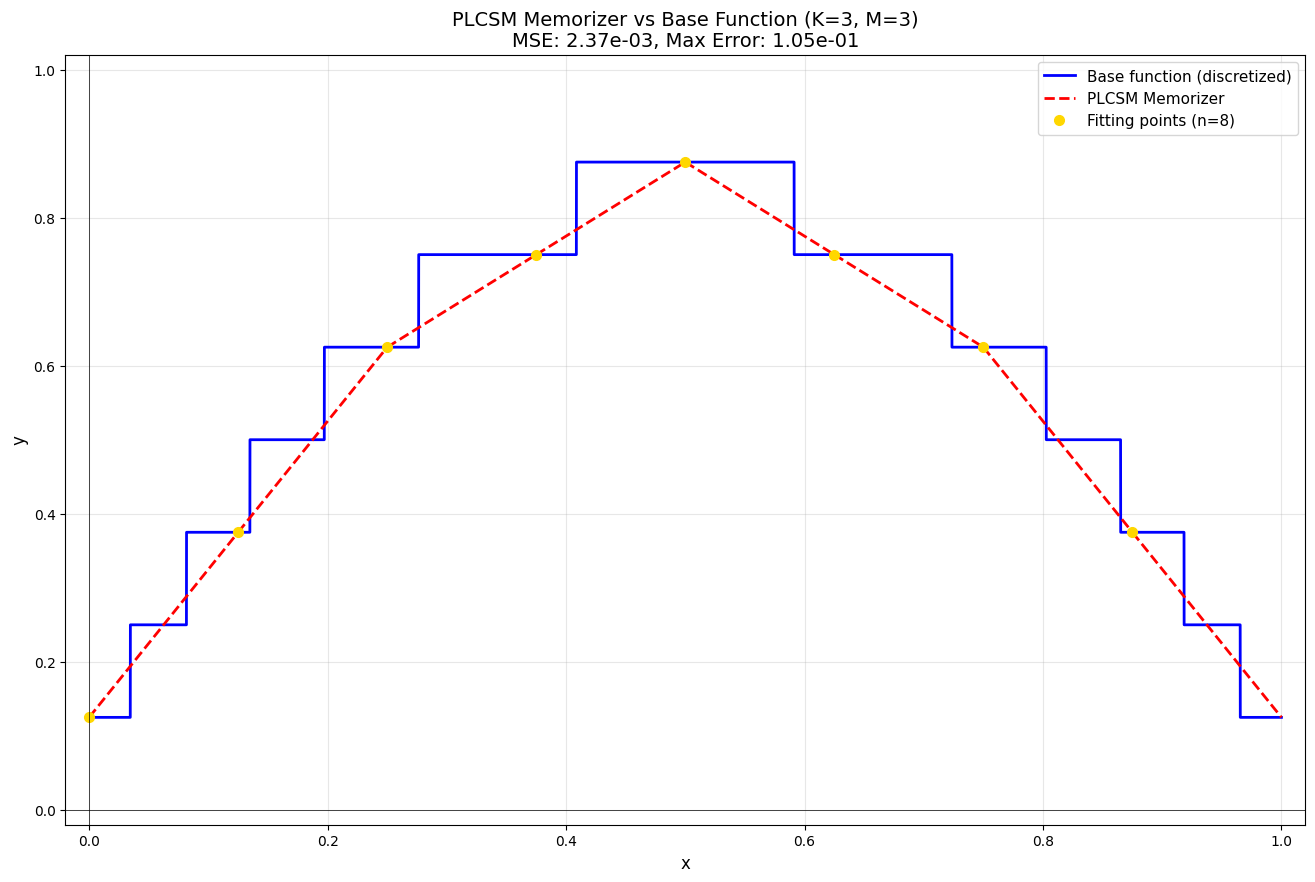

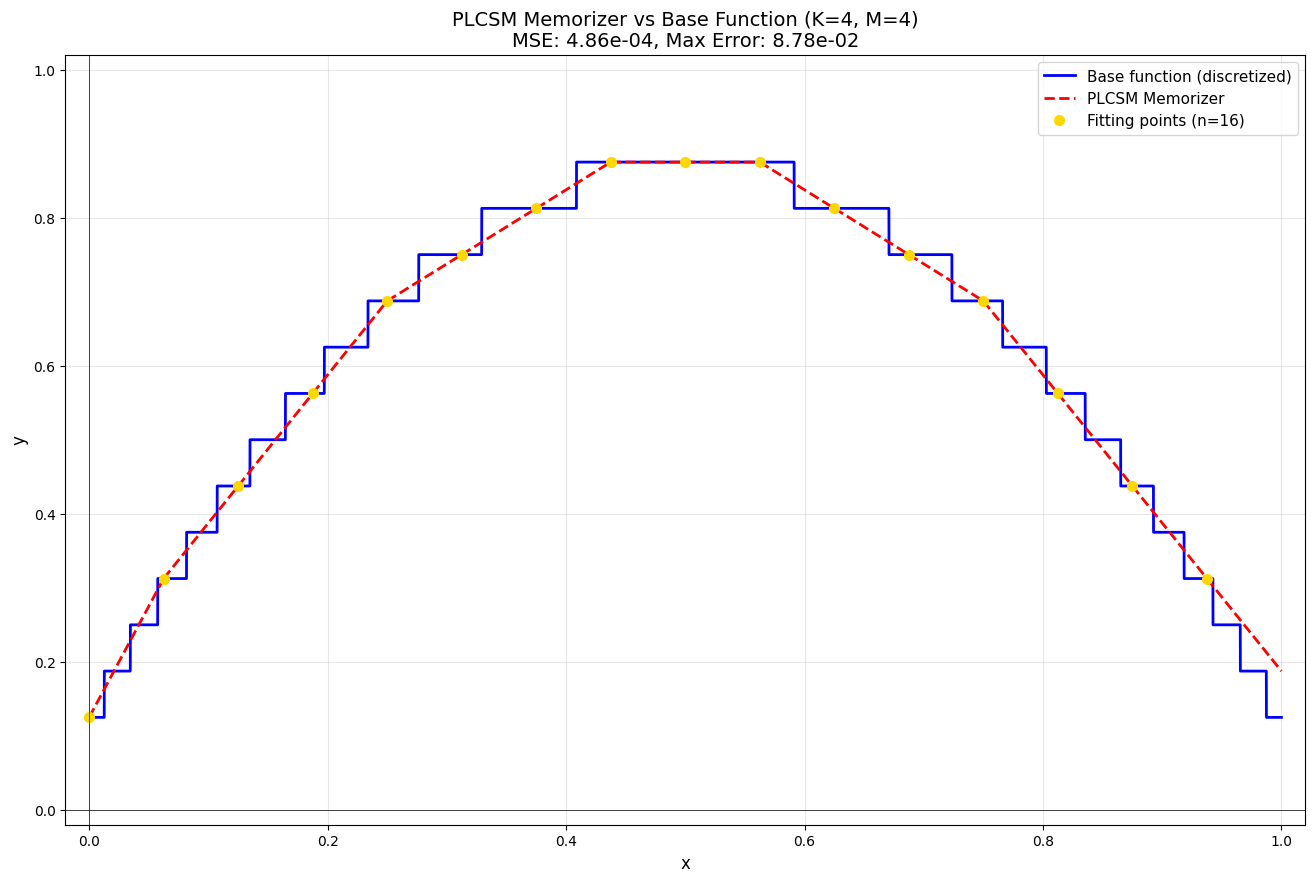

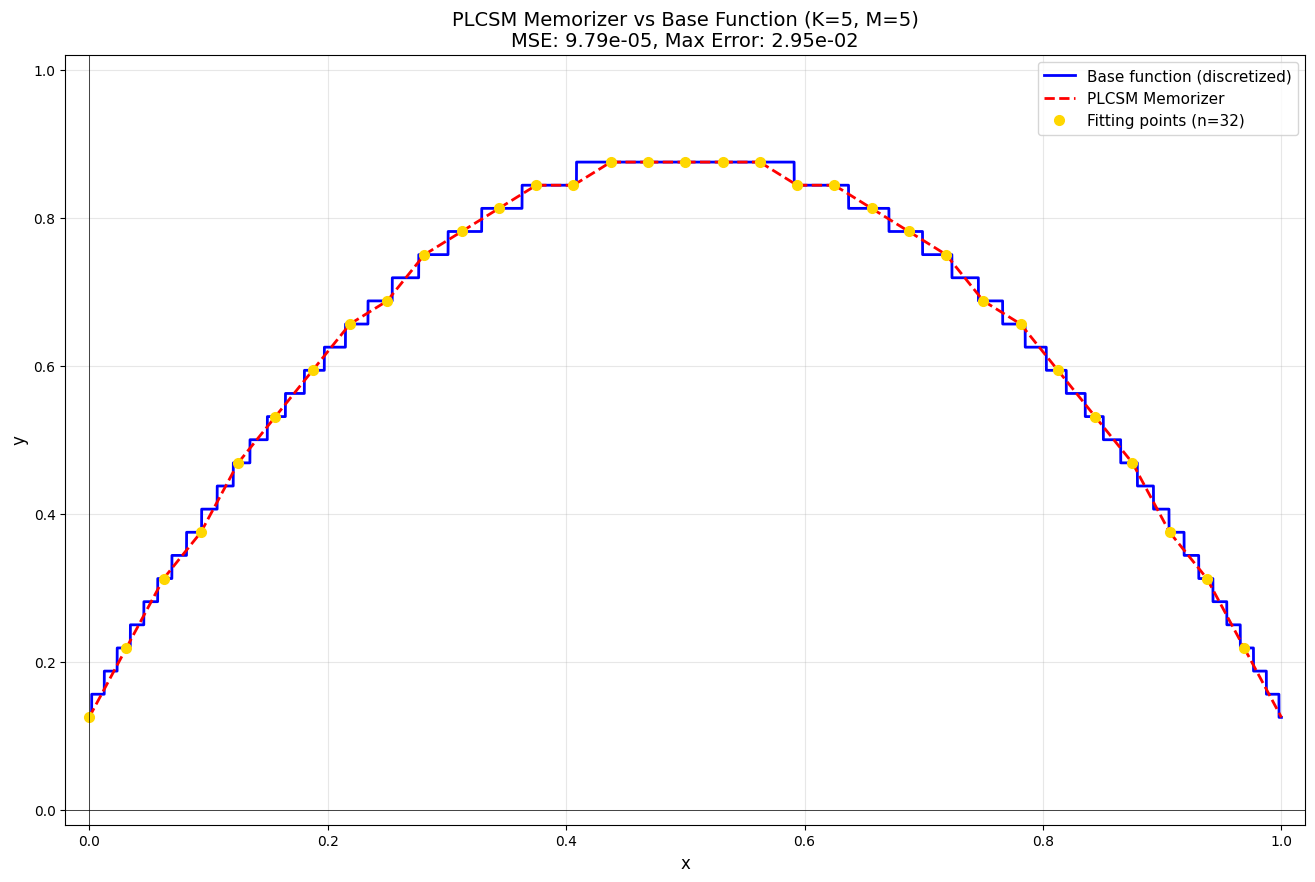

In [8]:
# Define parameter list for PLCSM memorizer demonstrations
# Each tuple is (K, M, flat_slope)
plcsm_param_list = [(2, 2, 1e-2), (3, 3, 1e-3), (4, 4, 1e-4), (5, 5, 1e-5)]

# Demonstrate PLCSM memorizer with base function comparison for multiple parameters
plcsm_memorizer = PLCSMMemorizer(base_function, K=2, M=2, flat_slope=1e-2, dtype=dtype, device=device)
plcsm_memorizer.plot_with_base_function_for_parameter_list(plcsm_param_list)

# Optional: Plot only the memorizers without base function (uncomment to use)
# Uncomment the line below to see only the PLCSM memorizer shapes for each parameter combination
# plcsm_memorizer.plot_for_parameter_list(plcsm_param_list)

### PLCSM Supremum Coding Scheme Evaluation

Now we evaluate the complete supremum coding scheme with the PLCSM memorizer. The approximation improves as the flat_slope parameter and encoder slope are decreased, or as $K$ and $M$ are increased.

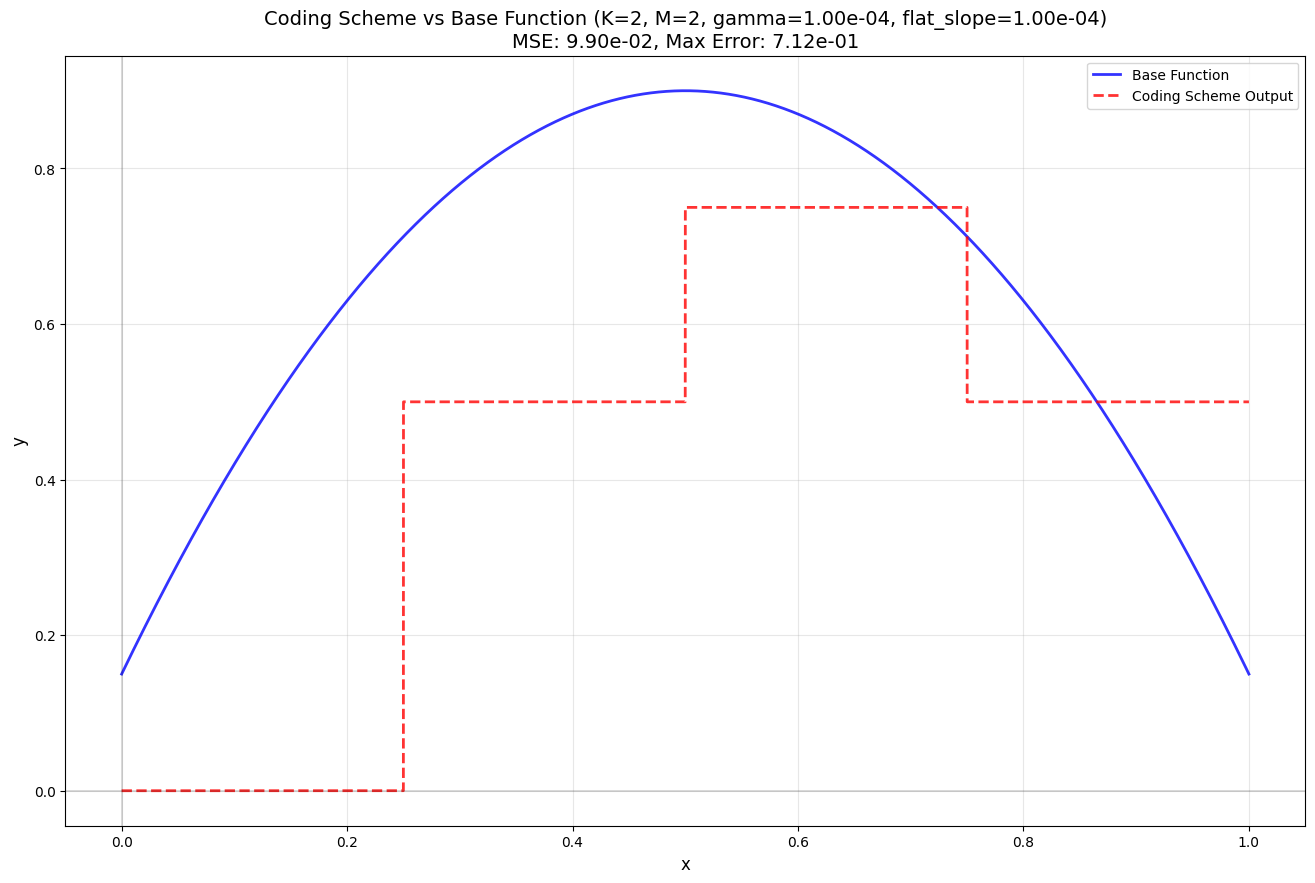

For Squared Shifted Function with PLCSM (Supremum) with parameters K=2, M=2, gamma=1.00e-04, flat_slope=1.00e-04:
 - L2 error: 3.15e-01, Max error: 7.12e-01


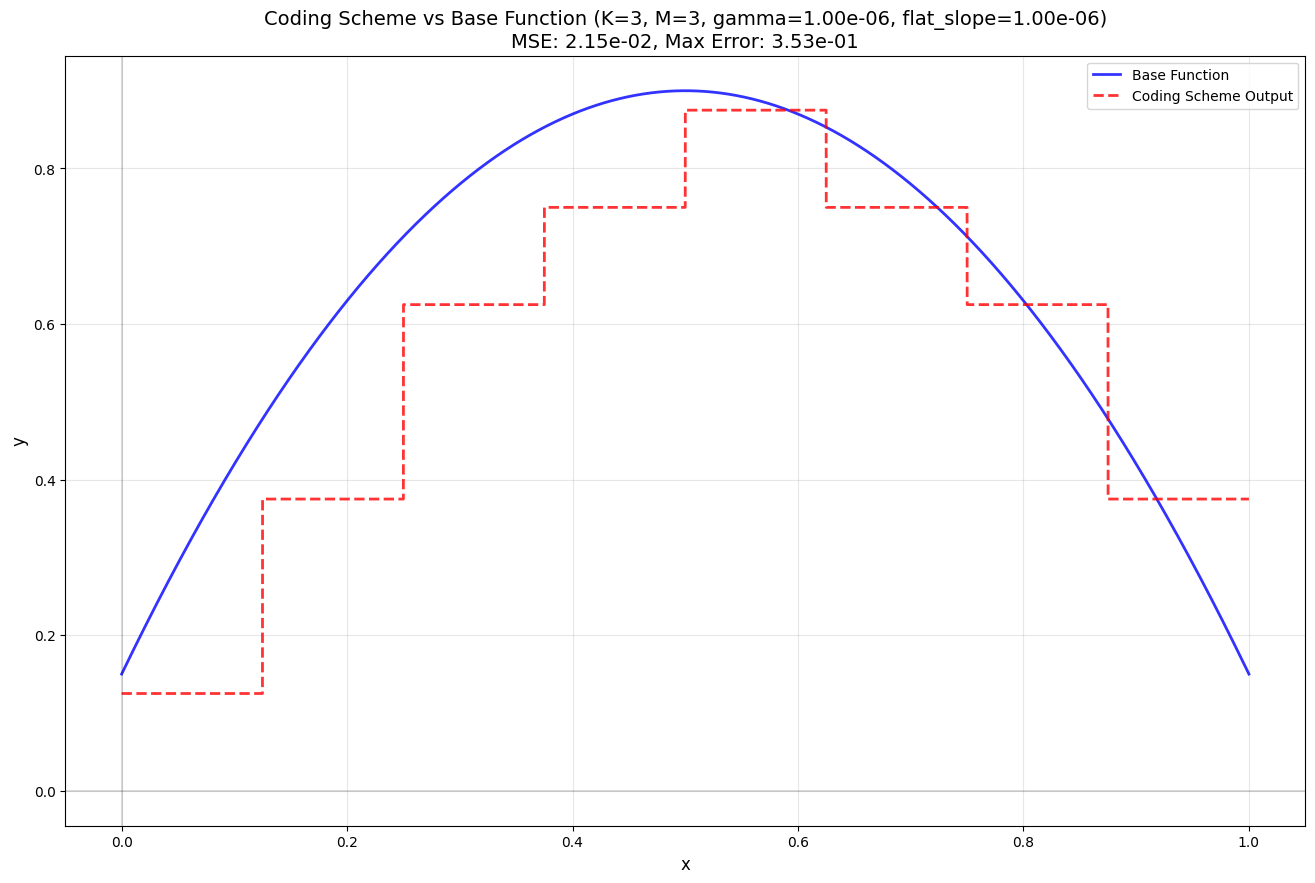

For Squared Shifted Function with PLCSM (Supremum) with parameters K=3, M=3, gamma=1.00e-06, flat_slope=1.00e-06:
 - L2 error: 1.47e-01, Max error: 3.53e-01


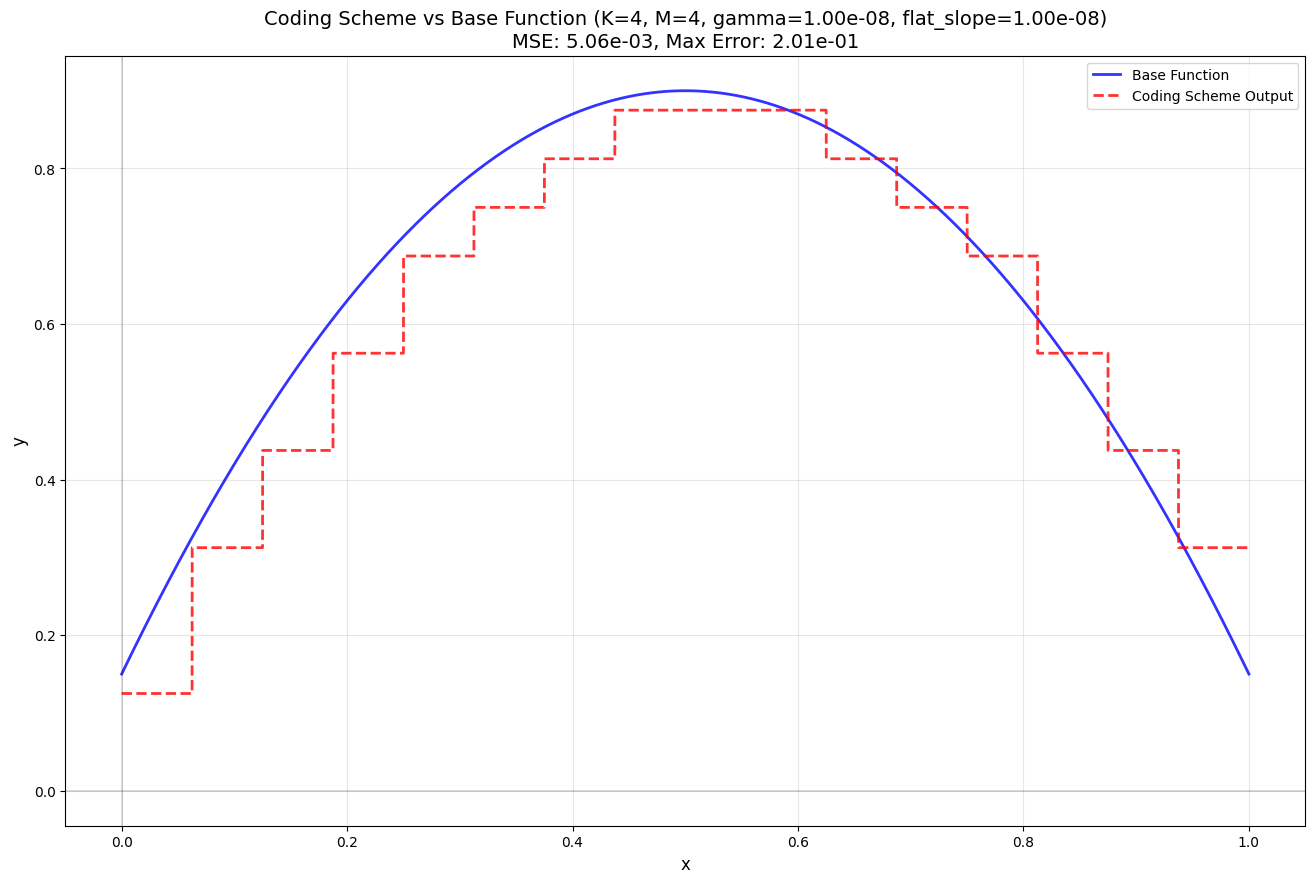

For Squared Shifted Function with PLCSM (Supremum) with parameters K=4, M=4, gamma=1.00e-08, flat_slope=1.00e-08:
 - L2 error: 7.11e-02, Max error: 2.01e-01


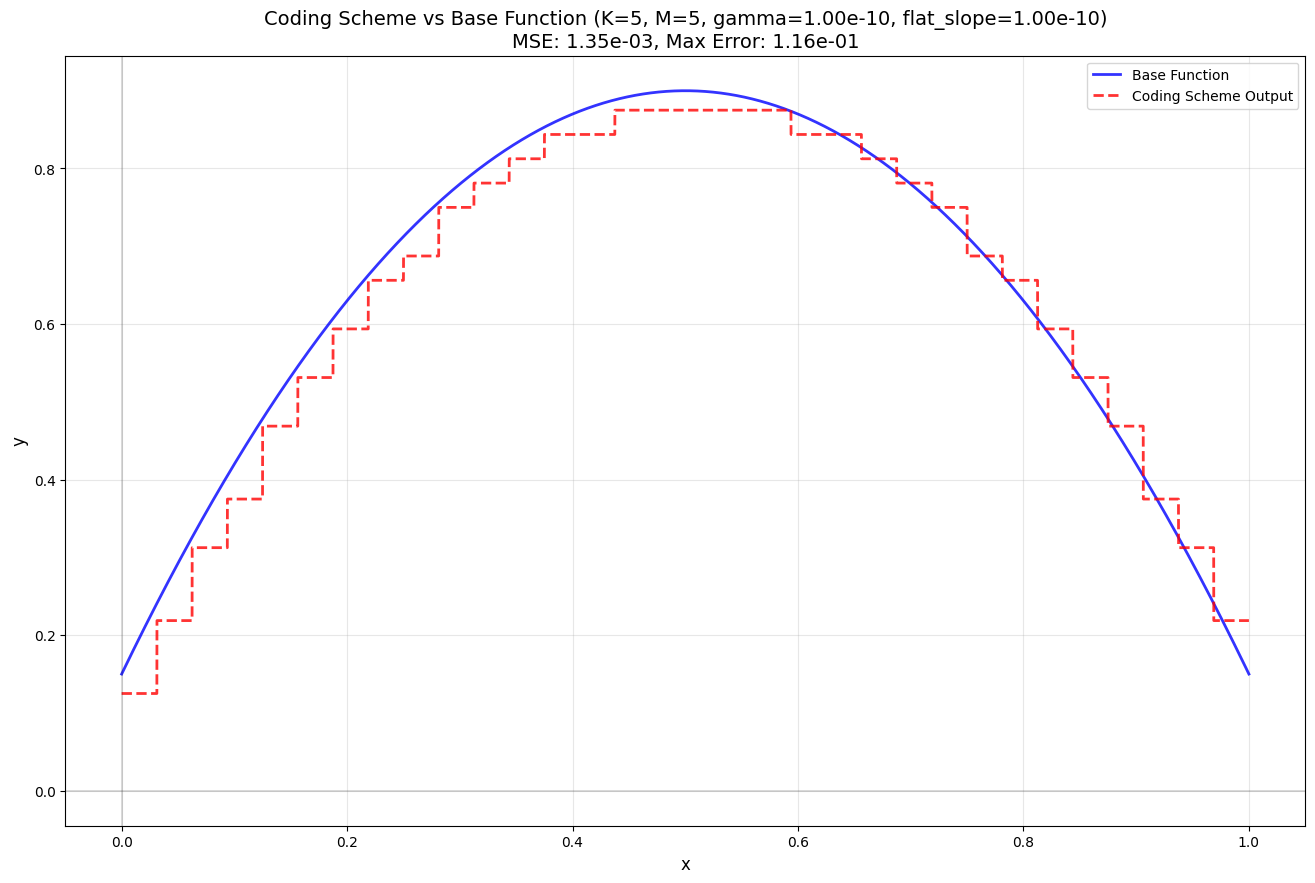

For Squared Shifted Function with PLCSM (Supremum) with parameters K=5, M=5, gamma=1.00e-10, flat_slope=1.00e-10:
 - L2 error: 3.68e-02, Max error: 1.16e-01


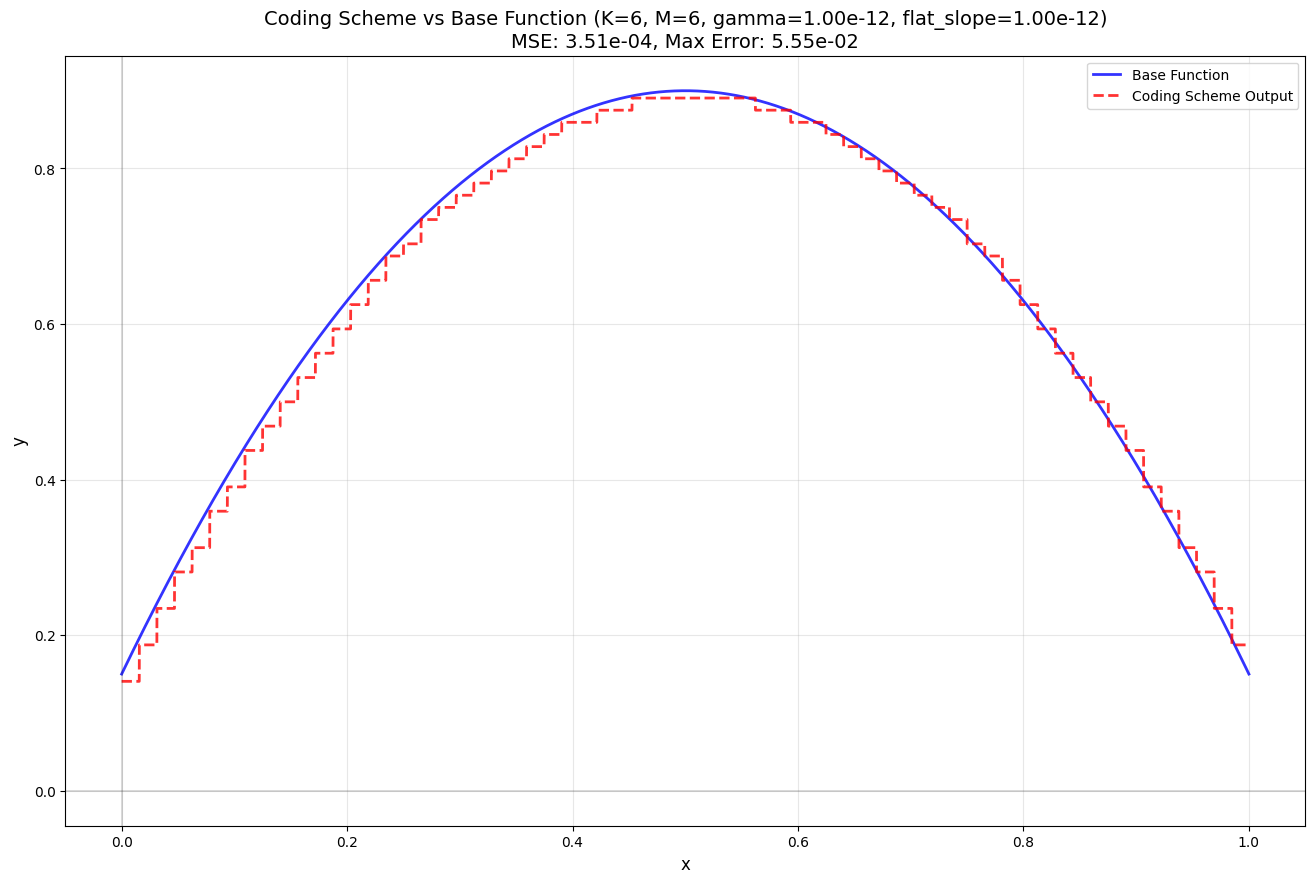

For Squared Shifted Function with PLCSM (Supremum) with parameters K=6, M=6, gamma=1.00e-12, flat_slope=1.00e-12:
 - L2 error: 1.87e-02, Max error: 5.54e-02


[(2, 2, 0.0001, 0.0001, 0.3147021828644665, 0.7123374868719996),
 (3, 3, 1e-06, 1e-06, 0.1466850315344778, 0.35292783251220416),
 (4, 4, 1e-08, 1e-08, 0.07108746003515035, 0.20053510339351488),
 (5, 5, 1e-10, 1e-10, 0.03677642998354774, 0.11568845677511141),
 (6, 6, 1e-12, 1e-12, 0.0187499669257427, 0.05544945443009497)]

In [9]:
# Create and evaluate supremum coding scheme with PLCSM memorizer
coding_scheme_plcsm_sup = CodingScheme1D(base_function, memorizer_type="plcsm", dtype=dtype, device=device, scheme_type="sup")

# Evaluate for multiple parameter combinations (errors are displayed in plots)
plcsm_sup_params = [(2,2,1e-4,1e-4), (3,3,1e-6,1e-6), (4,4,1e-8,1e-8), (5,5,1e-10,1e-10), (6,6,1e-12,1e-12)]
_ = coding_scheme_plcsm_sup.evaluate_for_list_of_parameters(plcsm_sup_params, f"{base_function_name} with PLCSM (Supremum)", plot=True)